# PSI Walkthrough



In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from psi import calculate_psi

In [7]:
sns.set_style("white")
rs = np.random.RandomState(5)

initial = rs.normal(size = 1000)
new = rs.normal(loc = 0.2, size = 1200)

- QQ plot

Common input length = 1000
(1000,)
(1000,)


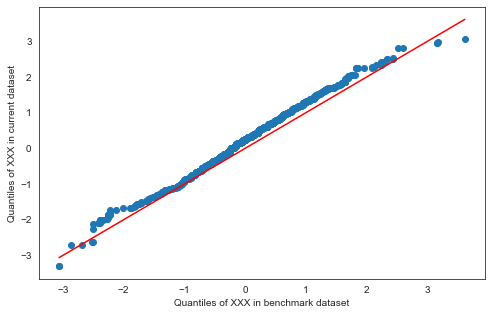

In [8]:
input_len = min(len(initial), len(new))
print(f'Common input length = {input_len}')
ini1 = np.random.choice(initial, input_len)
new1 = np.random.choice(new, input_len)
print(ini1.shape)
print(new1.shape)
ini1.sort()
new1.sort()

plt.figure(figsize=[8,5])
plt.scatter(ini1, new1)
plt.plot([min(ini1), max(ini1)], [min(ini1), max(ini1)], color = 'red')
plt.xlabel('Quantiles of XXX in benchmark dataset')
plt.ylabel('Quantiles of XXX in current dataset')
plt.show()

- Distribution

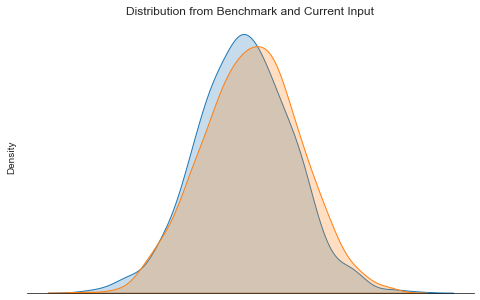

In [9]:
plt.figure(figsize=[8,5])
plot = sns.kdeplot(initial, shade=True, label='Benchmark')
plot = sns.kdeplot(new, shade=True, label='Current')
plot.set(yticklabels=[], xticklabels = [])
plt.title("Distribution from Benchmark and Current Input")
sns.despine(left=True)

In [4]:
#plot.get_figure().savefig('images/distributions.png', format='png', dpi=1000)

- PSI test
  1. PSI < 0.1: No Data Drift
  1. 0.1 <= PSI < 0.2: Need Further Investigation
  1. PSI > 0.2: Potential Data Drift/Breach/Anomaly

In [ ]:
def runPSI(benchmark_data, current_data, Target

In [5]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

buckets = 10
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
breakpoints = scale_range(raw_breakpoints, np.min(initial), np.max(initial))


In [6]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [7]:
df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df['Initial Percent'] = df['Initial Count'] / len(initial)
df['New Percent'] = df['New Count'] / len(new)

In [8]:
df['New Percent'][df['New Percent'] == 0] = 0.001

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
df

,Breakpoint Value,Bucket,Initial Count,New Count,Initial Percent,New Percent
0,-2.330642,1,1,0,0.01,0.001000
1,-1.801596,2,1,3,0.01,0.025000
2,-1.272550,3,4,6,0.04,0.050000
3,-0.743504,4,8,15,0.08,0.125000
4,-0.214458,5,27,18,0.27,0.150000
5,0.314588,6,22,23,0.22,0.191667
6,0.843633,7,16,26,0.16,0.216667
7,1.372679,8,12,14,0.12,0.116667
8,1.901725,9,6,9,0.06,0.075000
9,2.430771,10,3,3,0.03,0.025000


In [10]:
percents = df[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

In [11]:
percents.head()

,Bucket,Population,Percent
0,1,Initial Percent,0.01
1,2,Initial Percent,0.01
2,3,Initial Percent,0.04
3,4,Initial Percent,0.08
4,5,Initial Percent,0.27


/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


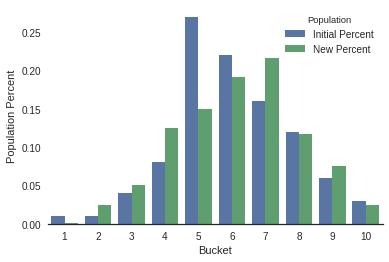

In [12]:
p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [13]:
#p.get_figure().savefig('images/constant_bins_percents.png', format='png', dpi=1000)

$PSI = \sum{}\Big(\big(Actual \% - Expected \%\big) \times ln\big(\dfrac{Actual \%}{Expected \%}\big)\Big)$

In [14]:
df['PSI'] = (df['New Percent'] - df['Initial Percent']) * np.log(df['New Percent'] / df['Initial Percent'])

In [15]:
df.head()

,Breakpoint Value,Bucket,Initial Count,New Count,Initial Percent,New Percent,PSI
0,-2.330642,1,1,0,0.01,0.001,0.020723
1,-1.801596,2,1,3,0.01,0.025,0.013744
2,-1.272550,3,4,6,0.04,0.050,0.002231
3,-0.743504,4,8,15,0.08,0.125,0.020083
4,-0.214458,5,27,18,0.27,0.150,0.070534


In [16]:
np.sum(df['PSI'])

0.15275591122393328

In [17]:
np.round(calculate_psi(initial, new, buckets=10, axis=1), 5) == np.round(np.sum(df['PSI']), 5)

True

In [18]:
breakpoints = np.stack([np.percentile(initial, b) for b in np.arange(0, buckets + 1) / (buckets) * 100])

In [19]:
initial_counts = np.histogram(initial, breakpoints)[0]
new_counts = np.histogram(new, breakpoints)[0]

In [20]:
df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
df['Initial Percent'] = df['Initial Count'] / len(initial)
df['New Percent'] = df['New Count'] / len(new)
df['New Percent'][df['New Percent'] == 0] = 0.001
percents = df[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


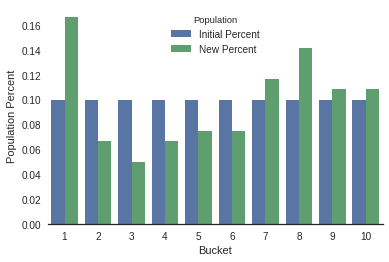

In [21]:
p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [22]:
#p.get_figure().savefig('images/percentile_bins_percents.png', format='png', dpi=1000)

In [23]:
calculate_psi(initial, new, buckettype='quantiles', buckets=10, axis=1)

0.12854351349505216